In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,LSTM, GRU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

######################

In [ ]:
contents = pd.read_csv("DataAirTrain.csv")
contents.fillna(0, inplace = True)
########################

In [ ]:
pm10_data = contents['PM-10'].values.reshape(-1, 1) ### lệnh reshape để chuyển thành numpy, sau đó mới scale được
scaler = MinMaxScaler(feature_range=(0, 1)) #scaler này của toàn bộ data
scaled_pm10_data = scaler.fit_transform(pm10_data)

In [ ]:
def gen_dataset(series, n_past_steps, n_future_steps, n_features):
  X = [] 
  Y = [] 
  for i in range(n_past_steps, series.shape[0]-n_future_steps+1):
    X.append(series[i-n_past_steps:i, n_features-1:])
    Y.append(series[i:i+n_future_steps, 0])

  return np.array(X).reshape(-1, n_past_steps, n_features), np.array(Y).reshape(-1, n_future_steps)

In [ ]:
X, Y = gen_dataset(scaled_pm10_data, 48, 48, 1)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, shuffle=False)
############################

In [ ]:
Y_train.shape

(2655, 48)

In [ ]:
def lstm_model(X_train, Y_train):
  regressor = Sequential()
  regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[-2], X_train.shape[-1])))
  regressor.add(Dropout(0.2))
  regressor.add(LSTM(units = 50, return_sequences = True))
  regressor.add(Dropout(0.2))
  regressor.add(LSTM(units = 50, return_sequences = True))
  regressor.add(Dropout(0.2))
  regressor.add(LSTM(units = 50))
  regressor.add(Dropout(0.2))
  regressor.add(Dense(units = Y_train.shape[-1])) 
  regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
  regressor.summary()

  return regressor


def train_model(X_train, Y_train, n_epochs):
  model = lstm_model(X_train, Y_train)
  hist = model.fit(X_train,
                 Y_train,
                 epochs=n_epochs,
                 batch_size=128,
                 shuffle=True,
                 validation_split=0.2,
                 verbose=1)
  
  return model

In [ ]:
def inverse_transform(forecasts, scaled_data, n_features, scaler):
  inverted = []
  for i in range(forecasts.shape[0]):
    forecast = forecasts[i].reshape(-1, 1)
    inv = scaler.inverse_transform(np.concatenate((forecast, scaled_data[-forecast.shape[0]:, n_features-1:]), axis =1))
    inverted.append(inv[:, 0])

  return np.array(inverted).reshape(-1, forecasts.shape[-1])


# plot the forecasts in the context of the original dataset
def plot_forecasts(original_data, forecasts, index, n_past_steps, n_future_steps, threshold):
  plt.figure(figsize=(15,5))
  plt.plot(original_data[index-n_past_steps:index+n_future_steps, 0], label='original PM-10 data')
  if original_data.shape[-1] > 1:
    plt.plot(original_data[index-n_past_steps:index+n_future_steps, 1], label='original PM-2-5 data')
    plt.plot(original_data[index-n_past_steps:index+n_future_steps, 2], label='original PM-1 data')
  plt.plot(range(n_past_steps, n_past_steps+n_future_steps+1), [original_data[index, 0]] + list(forecasts[index-n_past_steps]), label='predicted future data')
  plt.xticks(range(0, n_past_steps+n_future_steps+1, n_future_steps), range(index-n_past_steps, index+n_future_steps+1, n_future_steps))
 
  plt.legend()
  plt.title('Forecasts from hour ' + str(index))
  plt.show()

In [ ]:
model_uni = train_model(X_train, Y_train, 50)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 48, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 48, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 48, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 48, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 48, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [ ]:
Y_pred_uni = model_uni.predict(np.concatenate((X_train, X_test), axis=0))


104/104 [==============================] - 4s 35ms/step


In [ ]:
print('mean squared error:', mean_squared_error(np.concatenate((Y_train, Y_test), axis=0), Y_pred_uni))

mean squared error: 0.004714705237422799


In [ ]:
Y_pred_uni = inverse_transform(Y_pred_uni, scaled_pm10_data, n_features=1, scaler=scaler)
Y_train1 = inverse_transform(Y_train, scaled_pm10_data, n_features=1, scaler=scaler) 
Y_test1 = inverse_transform(Y_test, scaled_pm10_data, n_features=1, scaler=scaler)

In [ ]:
print('mean squared error:', mean_squared_error(np.concatenate((Y_train1, Y_test1), axis=0), Y_pred_uni))

mean squared error: 140.45615284056973


In [ ]:
print('mean absolute error:', mean_absolute_error(np.concatenate((Y_train1, Y_test1), axis=0), Y_pred_uni))

mean absolute error: 7.999337922194752


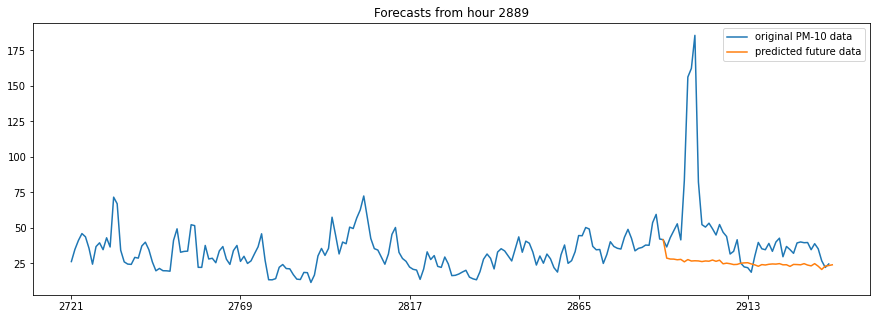

In [ ]:
plot_forecasts(pm10_data, Y_pred_uni, index=2889, n_past_steps=168, n_future_steps=48, threshold=155) # index must >= num_past_steps